In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import piecewise_regression
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings("ignore")

#Functions
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

def getStressStrainCurve(data_list, thickness_info = True, thickness_list = None, cut_off_load = 2):
    # convert in to um
    for i in range(len(data_list)):
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000
        # create stress column which is load / area, the area is 19.635 mm^2
        data_list[i]['stress (bar)'] = data_list[i]['Ch:Load (N)'] / 19.635 *10

    if thickness_info:
        thickness = thickness_list
        x_axis = 'strain'
        x_axis_label = 'Strain'
        # convert in to um
        for i in range(len(data_list)): 
            # create strain column which is displacement / thickness, the thickness is shown above
            data_list[i]['strain'] = data_list[i]['S:LVDT (um)'] / thickness[i]
    else:
        x_axis = 'S:LVDT (um)'
        x_axis_label = 'Displacement (um)'
    data_list_cleaned = []

    # Plot these in the same graph to compare them
    plt.figure(figsize=(8, 6))
    for i in range(len(data_list)):
        data_name = namestr(data_list[i], globals())
        data = data_list[i][data_list[i]['Ch:Load (N)'] > cut_off_load]
        data = data.loc[:data['Ch:Load (N)'].idxmax()]
        # shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data[x_axis] = data[x_axis] - data[x_axis].iloc[0]
        data_list_cleaned.append(data)
        plt.plot(data[x_axis], data['stress (bar)'], label=data_name)
    plt.xlabel(x_axis_label)
    plt.ylabel('Stress (bar)')
    plt.legend(loc='upper left')
    plt.show()

def denoiseData_SavitskyGolay(data_list, cut_off_load = 2): 
    for i in range(len(data_list)):
        # Apply Savitzky-Golay filter
        window_length = 400  # Length of the filter window (must be a positive odd integer)
        polyorder = 3       # Order of the polynomial used to fit the samples (must be less than window_length)

        #Align strain to 0
        data = data_list[i][data_list[i]['Ch:Load (N)'] > cut_off_load]
        data = data.loc[:data['Ch:Load (N)'].idxmax()]
        # shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data['strain'] = data['strain'] - data['strain'].iloc[0]
        data["stress (bar)"] = data["stress (bar)"] - data['strain'].iloc[0]

        y_smooth = savgol_filter(data["stress (bar)"], window_length, polyorder)
        
        # Plotting the results
        plt.figure(figsize=(10, 6))
        plt.plot(data['strain'], data["stress (bar)"], label='Noisy data')
        plt.plot(data['strain'], y_smooth, label='Smoothed data', color='red')
        plt.legend()
        plt.xlabel('strain')
        plt.ylabel('stress (bar)')
        plt.title('Savitzky-Golay Filter Smoothing')
        plt.show()

def validDataCheck_Correlation(data_list):
    df = pd.DataFrame()
    for i in range(len(data_list)):
        data_name = namestr(data_list[i], globals())
        df[data_name] = data_list[i]["stress (bar)"]
    pearson_corr = df.corr(method='pearson')

    print(pearson_corr)
    pearson_corr = pearson_corr.values.flatten().tolist()
    
    x = True
    for i in range(len(pearson_corr)):
        if math.ceil(pearson_corr[i]) < 0.95:
                x = False
    return x

def segmentingTheCurve_PiecewiseRegression(data_list):
    for i in range(len(data_list)):
        ms = piecewise_regression.ModelSelection(list(data_list[i]['strain']), list(data_list[i]['stress (bar)']), max_breakpoints=15)
        
    
        pw_fit = piecewise_regression.Fit(list(data_list[i]['strain']), list(data_list[i]['stress (bar)']), n_breakpoints=n)
        pw_fit.plot_fit(color="red", linewidth=2)
        pw_fit.plot_data(color="grey", s=1)
        pw_fit.plot_breakpoints()
        pw_fit.plot_breakpoint_confidence_intervals()
        plt.title("Piecewise Regression")
        plt.xlabel(x_axis_label)
        plt.ylabel("Stress (bar)")
        plt.show()
        pw_fit.summary()


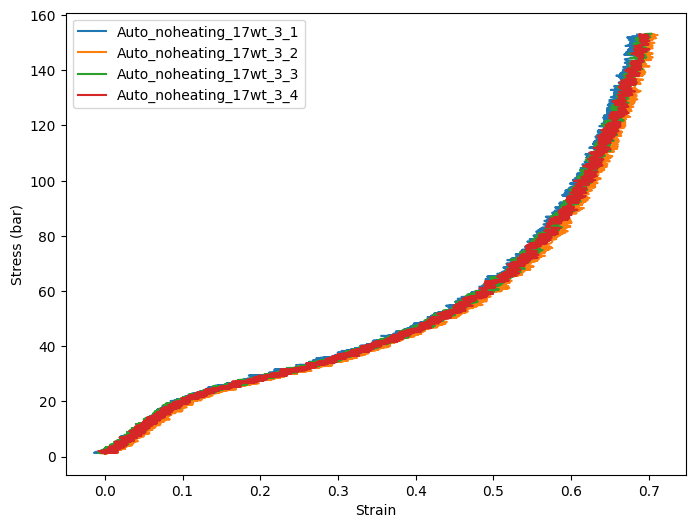

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 
Running fit with n_breakpoint = 4 . . 
Running fit with n_breakpoint = 5 . . 
Running fit with n_breakpoint = 6 . . 
Running fit with n_breakpoint = 7 . . 
Running fit with n_breakpoint = 8 . . 
Running fit with n_breakpoint = 9 . . 
Running fit with n_breakpoint = 10 . . 
Running fit with n_breakpoint = 11 . . 
Running fit with n_breakpoint = 12 . . 
Running fit with n_breakpoint = 13 . . 
Running fit with n_breakpoint = 14 . . 
Running fit with n_breakpoint = 15 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                 4.9364e+04         True   2.5283e+06 
1                  3.558e+04         True   5.1742e+05 
2                 3.0284e+04 

NameError: name 'n' is not defined

In [8]:
#Data
Auto_noheating_17wt_3_1 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-1-240212_02122024_180801.csv')
Auto_noheating_17wt_3_2 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-2-240212_02122024_181028.csv')
Auto_noheating_17wt_3_3 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-3-240212_02122024_181307.csv')
Auto_noheating_17wt_3_4 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-4-240212_02122024_181657.csv')

data_list_17_3 = [Auto_noheating_17wt_3_1, Auto_noheating_17wt_3_2, Auto_noheating_17wt_3_3, Auto_noheating_17wt_3_4]
thickness_17_3 = [110,105,105,105]

getStressStrainCurve(data_list_17_3, thickness_info = True, thickness_list = thickness_17_3)

segmentingTheCurve_PiecewiseRegression(data_list_17_3)